# News Summarization with an Attention Mechanism
Author: Andrii Zapukhlyi

## Objective

## Solution

## Import libraries

In [ ]:
import numpy as np
import pandas as pd
import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

## Dataset overview

In [24]:
df = datasets.load_dataset('cnn_dailymail', '3.0.0')

In [25]:
train = pd.DataFrame(df['train'])
val = pd.DataFrame(df['validation'])
test = pd.DataFrame(df['test'])

In [26]:
train = train.head(100000)
val = val.head(100000)
test = test.head(100000)

In [27]:
train.head()

,article,highlights,id
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a


In [28]:
print(len(train), len(val), len(test))

100000 13368 11490


In [29]:
train.sample(10)

,article,highlights,id
39152,(AOL Autos) -- Let's face it. Tires are usuall...,Tire Rack helps you shop online for tires and ...,a072a9e05bb4904e4d959bc66372a8ee59576e80
57686,"(CNN) -- U.S. journalist Austin Tice, who went...",The Washington Post says Austin Tice is being ...,78164c2fc6a424b66958f0cef0d8338419b8999d
74301,North Korea fired two projectiles Sunday that ...,"U.S. calls on North Korea to stop ""provocative...",656508f23e03de6cfb418d5ae968ec3a245c767b
78115,The U.S. Coast Guard is searching for a 13-yea...,Boy jumped off cliff near Hapuna Beach State P...,522501bd67426632f382f75a7dcceb8bb7ae6938
7794,(CNN) -- The United States will withdraw anoth...,Thousands more troops in Iraq expected to retu...,a5b383eb30a0d031b3d03bee307f73262f3348c1
1898,"CLEARWATER, Florida (CNN) -- One of four miss...",Search for missing men narrows after one found...,f3fe02696e16a3478c97c5c34a52f8e5d3d1d9ea
69062,Washington (CNN) -- At times it seemed as if M...,Martha Raddatz won kudos as moderator of the v...,4403df98177b873615d9ebfc96d9377ec506067a
48435,"TEGUCIGALPA, Honduras (CNN) -- Five people di...",NEW: Larger planes will be required to land at...,ee4d1b03b9612053daba2867e5d8befea46d8c73
44936,(CNN) -- There was no feeling in Matthias Lanz...,Matthias Lanzinger underwent leg amputation af...,0ba6ee01329bf2d52fc97775b8f8e475204ce057
9132,LONDON (England) CNN -- Could the era of spend...,Global warning signs that an era of prosperity...,27d97c98917f7db0782a702be5992ef8cf6eef05


In [30]:
train.describe()

,article,highlights,id
count,100000,100000,100000
unique,96914,96186,100000
top,NEW YORK (CNN) -- After spending nearly 28 ye...,This page includes the show Transcript and the...,9137ec271a8ec057e50bf6a3488ba3365d36a14f
freq,3,83,1


In [31]:
def delete_wrong_scraped(set):
    wrong_scraped = ["This page includes the show Transcript", "The daily transcript is a written version", "Use the weekly Newsquiz to test your", "Use these questions to help students understan"]

    for elem in wrong_scraped:
        set = set[~set['highlights'].str.contains(elem, na=False, case=False)]

    return set

train = delete_wrong_scraped(train)
val = delete_wrong_scraped(val)
test = delete_wrong_scraped(test)

In [32]:
print(train.describe())
print(val.describe())
print(test.describe())

                                                  article  \
count                                               99518   
unique                                              96432   
top     NEW YORK (CNN)  -- After spending nearly 28 ye...   
freq                                                    3   

                                               highlights  \
count                                               99518   
unique                                              96135   
top     Rick Steves writes European travel guidebooks ...   
freq                                                    9   

                                              id  
count                                      99518  
unique                                     99518  
top     9a03006074a2d681494d67b970d2736fa2ed35f6  
freq                                           1  
                                                  article  \
count                                               13351   
unique     

In [33]:
print("Number of NA values in sets:")
print(train.isna().sum().sum())
print(val.isna().sum().sum())
print(test.isna().sum().sum())

print("Number of duplicates in sets:")
print(train.duplicated().sum())
print(val.duplicated().sum())
print(test.duplicated().sum())

Number of NA values in sets:
0
0
0
Number of duplicates in sets:
0
0
0


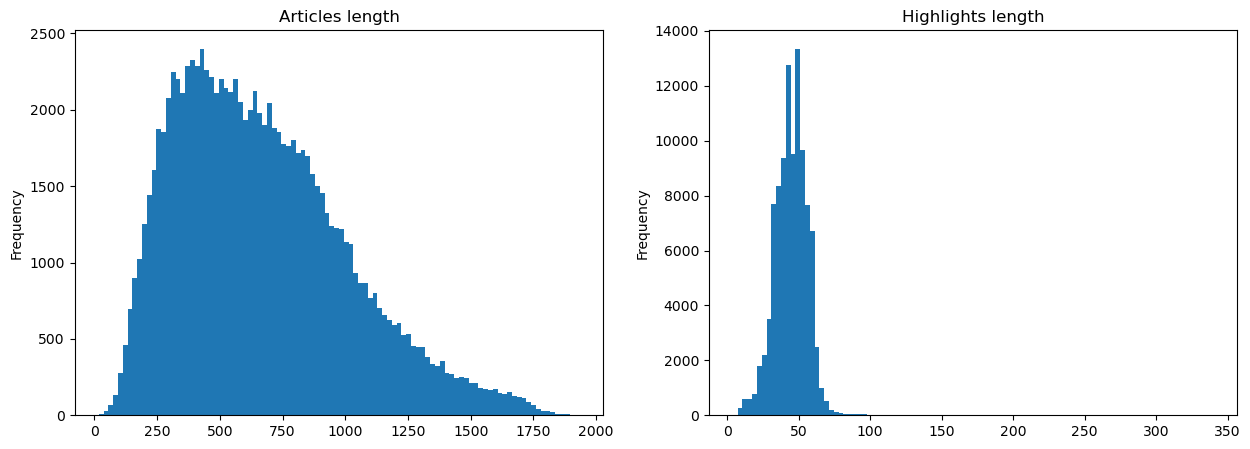

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

train["article"].apply(lambda x: len(x.split())).plot(kind='hist', bins = 100, ax = ax[0])
ax[0].set_title('Articles length')

train["highlights"].apply(lambda x: len(x.split())).plot(kind='hist', bins = 100)
ax[1].set_title('Highlights length')

plt.show()

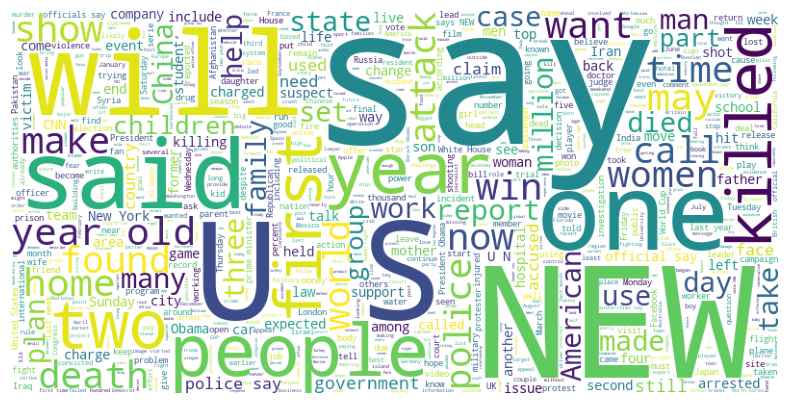

In [35]:
from wordcloud import WordCloud

text_data = " ".join(train['highlights'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', max_words=1000).generate(text_data)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\andri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


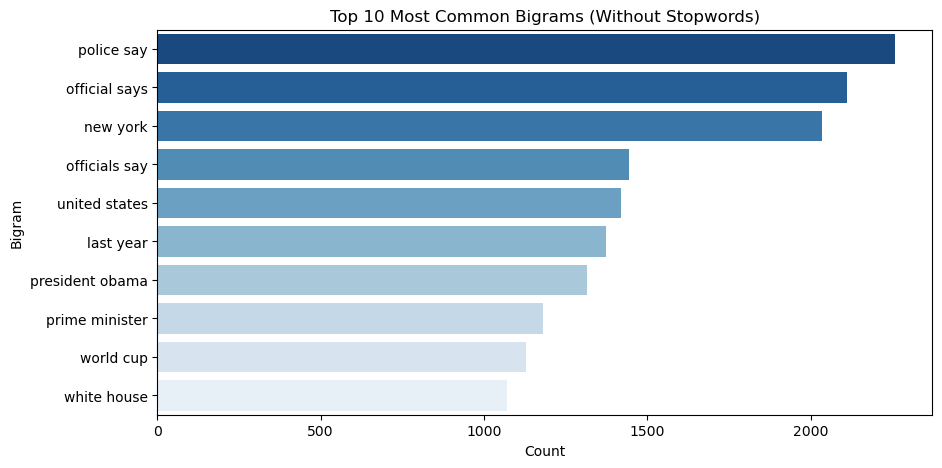

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from collections import Counter
import nltk

stop_words = set(stopwords.words("english"))

def get_bigrams(text):
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalnum() and word not in stop_words]
    bigrams = list(nltk.bigrams(words))
    return [" ".join(bigram) for bigram in bigrams]

bigrams = []
for t in train["highlights"]:
    bigrams.extend(get_bigrams(t))

bigram_counts = Counter(bigrams).most_common(10)
bigram_df = pd.DataFrame(bigram_counts, columns=["Bigram", "Count"])

plt.figure(figsize=(10, 5))
sns.barplot(x="Count", y="Bigram", data=bigram_df, hue = "Bigram", palette="Blues_r")
plt.title("Top 10 Most Common Bigrams (Without Stopwords)")
plt.show()

## Data preprocessing

In [37]:
import re

metadata_pattern = re.compile(
    r"^By\s+.*?\.\s+"  # Removes "By . Author Name ."
    r"|PUBLISHED:\s*\.*\s*\d{1,2}:\d{2}\s*[A-Z]{2,3},\s*\d{1,2}\s*\w+\s*\d{4}\s*\.*\s*\|?\s*UPDATED:\s*\.*\s*\d{1,2}:\d{2}\s*[A-Z]{2,3},\s*\d{1,2}\s*\w+\s*\d{4}\s*\.*"  # Removes PUBLISHED / UPDATED timestamps
    r"|Last updated at \d{1,2}:\d{2} [APM]{2} on \d{1,2}(st|nd|rd|th)? \w+ \d{4} \."  # Removes "Last updated at ..."
    r"|^.*?--\s*"  # Removes source prefixes like "(CNN) --", "(BBC) --"
    r"|^Follow\s+@@\S+\s+\.\s+"  # Removes "Follow @username . "
    r"|UPDATED: .*? \. "  # Removes text after "UPDATED: ..."
)

def delete_metadata(text):
    if not isinstance(text, str):
        return text
    
    text = metadata_pattern.sub('', text)
    return ' '.join(text.split())

train["article"] = train["article"].apply(delete_metadata)
val["article"] = val["article"].apply(delete_metadata)

In [38]:
train.sample(10)

,article,highlights,id
74072,"minus their homes,"" Durrah said. ""They have to...",More than 500 people attend vigil Wednesday ev...,2d32d0e1d9a2ba4214480821584ff96921722728
19831,"Since the days of George Washington, U.S. pres...",Franklin Pierce's son was killed while on a ra...,d8dbf8ca9feb0f9f4fa810576069b9bdda276f65
57190,Things have never been more exciting in Africa...,"For Africans, the internet is a content enable...",da3f1bdd6b6f78c48b1b0e204ce396cca18bd9b9
90899,Milk given to patient by staff but unharmed . ...,Milk given to patient by staff but unharmed .\...,d84b700b77a53881b506e4a2dba0ec0f0432a02d
27640,Reclusive pop icon Michael Jackson will perfor...,Michael Jackson announces 10 concerts at Londo...,84f7244a9e71775985d8f58dcb65817688be7c23
68277,Hillary Clinton has spent the final moments of...,Hillary Clinton isn't saying whether she'll ru...,d1521755ce7d4b533ef20235c2bd87538626b604
44808,A day after Miriam Carey ran a barricade and l...,NEW: Miriam Carey was diagnosed with postpartu...,d490ea364f1d7f610e49819d5bdb303f66790951
91601,Matthew VanDyke told his mother and girlfriend...,Matthew VanDyke told his mother and girlfriend...,2fb9c6d4688407a467c5dece3d77331ccd92173c
86708,"one, two, we don't know how many -- were put o...",43 students intending to protest in Iguala van...,fa2da0561af23aa3c99d2b47fb0213f7b38eaf6d
20665,Spanish underdogs Levante kept up their remark...,Levante beat Real Sociedad 3-2 to stay top of ...,d57f65346efd43aa75a3274609a63bc6e4b61e2b


In [39]:
def clean_text(text_series):
    text_series = text_series.str.lower()

    text_series = text_series.str.replace(r"http\S+|www\S+|https\S+", '', regex=True)
    text_series = text_series.str.replace(r"@\w+|#\w+", '', regex=True)
    text_series = text_series.str.replace(r"[^a-zA-Z.,!?]+", ' ', regex=True)
    text_series = text_series.str.replace(r"([.,!?])", r" \1 ", regex=True)
    text_series = text_series.str.replace(r'\n+', ' ', regex=True)
    text_series = text_series.str.strip()
    return text_series

train["article"] = clean_text(train["article"])
train["highlights"] = clean_text(train["highlights"])

In [40]:
train = train.dropna()
val = val.dropna()

In [41]:
import spacy

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def tokenize_text(texts):
    texts = list(texts)
    return [[token.text for token in doc] for doc in nlp.pipe(texts, batch_size=128, n_process=16)]

X_train_tokenized = tokenize_text(train["article"])
y_train_tokenized = tokenize_text(train["highlights"])
X_val_tokenized = tokenize_text(val["article"])

In [42]:
from collections import Counter

word_counts = Counter(token for sentence in train["article"] + train["highlights"] for token in sentence)
vocab = {word: i+1 for i, (word, _) in enumerate(word_counts.most_common())}
vocab["<PAD>"] = 0

def encode(tokens, vocab):
    return [vocab.get(token, vocab["<PAD>"]) for token in tokens]

X_train_idx = [encode(tokens, vocab) for tokens in X_train_tokenized]
Y_train_idx = [encode(tokens, vocab) for tokens in y_train_tokenized]
X_val_idx = [encode(tokens, vocab) for tokens in X_val_tokenized]

In [43]:
from torch.nn.utils.rnn import pad_sequence

def pad_sequences(sequences, pad_idx=0):
    tensor_sequences = [torch.tensor(seq) for seq in sequences]
    return pad_sequence(tensor_sequences, batch_first=True, padding_value=pad_idx)

X_train_padded = pad_sequences(X_train_idx, pad_idx=vocab["<PAD>"])
Y_train_padded = pad_sequences(Y_train_idx, pad_idx=vocab["<PAD>"])
X_val_padded = pad_sequences(X_val_idx, pad_idx=vocab["<PAD>"]) 

In [44]:
print(X_train_padded.shape, Y_train_padded.shape, X_val_padded.shape) 

torch.Size([99518, 2506]) torch.Size([99518, 398]) torch.Size([13351, 2178])


In [45]:
class SummarizationDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    
train_dataset = SummarizationDataset(X_train_padded, Y_train_padded)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
class Encoder(nn.Module):
    